## 변수선택법

### 1. 전진선택법(Forward Selection)
### 2. 후진소거법(Backward Elimination)
### 3. 단계적선택법(Stepwise Selection)

In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [92]:
last = pd.read_excel("data/last_자전거이용비율수정.xlsx")
last.fillna(0, inplace=True) # 결측값 0으로 치환 
last = last.drop(last.columns[[0, 6, 14]], axis=1) # unnamed:0 칼럼 지우기
last = last.set_index('동')
last.head()

,경사도,자전거도로길이,총거치대수,총대여수,인구,면적,인구밀도,지하철역개수,버스정거장개수,접근성,교통편
동,,,,,,,,,,,
가락1동,-15.5247,7150,115.0,74652.0,27716,1.34,20684,1,13,12.686567,17
가락2동,-39.3115,4704,45.0,33583.0,33920,0.96,35333,0,23,23.958333,23
가락본동,-30.7845,6932,55.0,25487.0,27876,1.13,24669,2,25,29.203540,33
가리봉동,-21.8088,0,10.0,5621.0,15250,0.40,38125,0,9,22.500000,9
가산동,-12.9490,2108,258.0,160033.0,24455,2.52,9704,2,111,47.222222,119


In [94]:
feature_columns = last.columns.difference(["총대여수"]) # Target column 

X = last[feature_columns]
y = last.총대여수

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(296, 10) (128, 10) (296,) (128,)


In [95]:
# train & 회귀모델 적합, 모든 변수를 때려넣었다.

# 회귀분석을 위해 for b0, 상수항 추가
train_x_ = sm.add_constant(train_x, has_constant = "add")

full_model = sm.OLS(train_y, train_x_)
fitted_full_model = full_model.fit()

fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     82.67
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           2.71e-74
Time:                        17:03:06   Log-Likelihood:                -3483.8
No. Observations:                 296   AIC:                             6988.
Df Residuals:                     286   BIC:                             7025.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1888.4387   8179.360      0.231      0.818   -1.42e+04     1.8e+04
경사도          116.7762     57.887      2.017      0.045       2.837     230.715
교통편         2140.2673    622.293      3.439      0.001     915.413    3365.122
면적         -1553.8582   1887.577     -0.823      0.411   -5269.164    2161.447
버스정거장개수    -2190.1501    578.859     -3.784      0.000   -3329.515   -1050.785
인구             0.1032      0.347      0.297      0.767      -0.580       0.787
인구밀도           0.1014      0.326      0.311      0.756      -0.540       0.742
자전거도로길이        2.2932      0.567      4.046      0.000       1.178       3.409
접근성           69.4669    277.871      0.250      0.803    -477.465     616.399
지하철역개수      1082.6043    292.447      3.702      0.000     506.983    1658.226
총거치대수        499.8940     31.856     15.693      0.000     437.193     562.595
==============================================================================
Omnibus:                      147.609   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2462.315
Skew:                           1.594   Prob(JB):                         0.00
Kurtosis:                      16.766   Cond. No.                     3.01e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.05e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [96]:
# VIF를 통한 다중공선성 확인 --> 교통편, 버스정거장개수, 지하철역개수 inf

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_x_.values, i) for i in range(train_x_.shape[1])]
vif["features"] = train_x_.columns
vif

C:\Users\juhee\anaconda3\envs\pydatavenv\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,19.553064,const
1,1.653659,경사도
2,inf,교통편
3,3.050628,면적
4,inf,버스정거장개수
5,3.092275,인구
6,4.450720,인구밀도
7,1.692175,자전거도로길이
8,4.517215,접근성
9,inf,지하철역개수


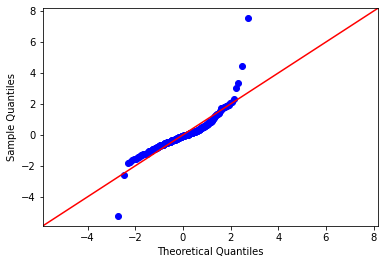

In [97]:
# 학습데이터의 잔차 확인

res = fitted_full_model.resid

# q-q plot을 통한 잔차의 정규분포 확인
fig = sm.qqplot(res, fit = True,line = '45')

In [101]:
# MSE 구하기
from sklearn.metrics import mean_squared_error

x1 = last[['경사도', '자전거도로길이', '총거치대수', '인구', '면적', '인구밀도', 
       '지하철역개수', '버스정거장개수', '접근성', '교통편']]
x1_ = sm.add_constant(x1, has_constant = "add")
target = last[['총대여수']]

X = x1_
y = target

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 1)

# 학습데이터와 검증데이터를 7:3으로 분리한다.
# random_state고정을 통해 그때마다 똑같은 값을 분류하도록 한다.
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

fit_train1 = sm.OLS(train_y,train_x)
fit_train1 = fit_train1.fit()

mse1 = mean_squared_error(y_true = test_y["총대여수"], y_pred = fit_train1.predict(test_x))

print(mse1)

1440403417.530222


### 전진석택법(step=1)

In [102]:
import time
import itertools 

def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

### 전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
        
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])
		

In [103]:
Forward_best_model = forward_model(X=train_x, y=train_y)

Processed  10 models on 1 predictors in 0.02700352668762207
Selected predictors: ['총거치대수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BD19B88>
Processed  9 models on 2 predictors in 0.021997690200805664
Selected predictors: ['총거치대수', '자전거도로길이', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47CD40648>
Processed  8 models on 3 predictors in 0.019001483917236328
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47CCFFFC8>
Processed  7 models on 4 predictors in 0.017001628875732422
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', '지하철역개수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47CCFAEC8>
Processed  6 models on 5 predictors in 0.012998819351196289
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', '지하철역개수', '인구밀도', 'const'] AIC:  <statsmod

In [104]:
Forward_best_model.aic

6913.732668881649

In [105]:
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     73.13
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           2.38e-49
Time:                        17:03:44   Log-Likelihood:                -3450.9
No. Observations:                 296   AIC:                             6914.
Df Residuals:                     290   BIC:                             6936.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총거치대수        460.5227     34.987     13.163      0.000     391.663     529.383
자전거도로길이        2.0933      0.500      4.183      0.000       1.108       3.078
경사도          120.4445     48.711      2.473      0.014      24.572     216.317
지하철역개수      5464.2692   2218.556      2.463      0.014    1097.755    9830.783
인구밀도           0.2623      0.163      1.605      0.110      -0.059       0.584
const       4135.0480   6714.695      0.616      0.538   -9080.667    1.74e+04
==============================================================================
Omnibus:                       95.855   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.330
Skew:                           1.024   Prob(JB):                    1.26e-193
Kurtosis:                      11.236   Cond. No.                     1.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 후진소거법(step=1)

In [120]:
import time
import itertools 

def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
    	results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y):
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Bmodels["model"].dropna().iloc[0])

In [121]:
Backward_best_model = backward_model(X=train_x, y= train_y)

Processed  10 models on 9 predictors in 0.03600287437438965
Selected predictors: ['경사도', '교통편', '버스정거장개수', '인구', '인구밀도', '자전거도로길이', '접근성', '지하철역개수', '총거치대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BCF91C8>
Processed  9 models on 8 predictors in 0.024002790451049805
Selected predictors: ['경사도', '교통편', '버스정거장개수', '인구', '자전거도로길이', '접근성', '지하철역개수', '총거치대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BCEE648>
Processed  8 models on 7 predictors in 0.016991615295410156
Selected predictors: ['경사도', '교통편', '버스정거장개수', '인구', '자전거도로길이', '접근성', '총거치대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47CD1B7C8>
Processed  7 models on 6 predictors in 0.014002323150634766
Selected predictors: ['경사도', '교통편', '버스정거장개수', '인구', '자전거도로길이', '총거치대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47

In [123]:
Backward_best_model.aic

6914.266829290084

In [124]:
Backward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     52.97
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           3.32e-48
Time:                        17:08:56   Log-Likelihood:                -3449.1
No. Observations:                 296   AIC:                             6914.
Df Residuals:                     288   BIC:                             6944.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
경사도           98.3281     51.725      1.901      0.058      -3.478     200.134
교통편         1193.0092    550.568      2.167      0.031     109.361    2276.657
버스정거장개수    -1511.2093    573.342     -2.636      0.009   -2639.682    -382.736
인구             0.4512      0.212      2.133      0.034       0.035       0.868
자전거도로길이        2.0865      0.513      4.064      0.000       1.076       3.097
접근성          210.0206    146.855      1.430      0.154     -79.025     499.066
총거치대수        477.1170     40.539     11.769      0.000     397.327     556.907
const        998.2981   7023.430      0.142      0.887   -1.28e+04    1.48e+04
==============================================================================
Omnibus:                       91.113   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              828.679
Skew:                           0.961   Prob(JB):                    1.13e-180
Kurtosis:                      10.968   Cond. No.                     1.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 단계적선택법

In [150]:
def Stepwise_model(X,y):
    stepModels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    predictors = []
    SmodelBefore = processSubset(X,y,predictors+['const'])['AIC']
    #변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const']))+1):
        forwardResult = forward(X,y,predictors)
        print("forward")
        stepModels.loc[i] = forwardResult
        predictors = stepModels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        backwordResult = backward(X,y,predictors)
        if backwordResult['AIC'] < forwardResult['AIC']:
            stepModels.loc[i] = backwordResult
            predictors=stepModels.loc[i]["model"].model.exog_names
            smodelBefore=stepModels.loc[i]["AIC"]
            predictors=[k for k in predictors if k != 'const']
            print('backward')
        if stepModels.loc[i]["AIC"] > SmodelBefore:
            break
        else:
            smodelBefore = stepModels.loc[i]["AIC"]
    toc=time.time()
    print("Total elapsed time : ", (toc - tic), "seconds")
    return (stepModels['model'][len(stepModels['model'])])

In [151]:
Stepwise_best_model = Stepwise_model(X=train_x, y= train_y)

Processed  10 models on 1 predictors in 0.03300786018371582
Selected predictors: ['총거치대수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BBCBCC8>
forward
Processed  1 models on 0 predictors in 0.0039958953857421875
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BBD1D88>
Processed  9 models on 2 predictors in 0.025982379913330078
Selected predictors: ['총거치대수', '자전거도로길이', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BD001C8>
forward
Processed  2 models on 1 predictors in 0.006999969482421875
Selected predictors: ['총거치대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002E47BC95FC8>
Processed  8 models on 3 predictors in 0.016000032424926758
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper obj

In [156]:
Stepwise_best_model.aic

6913.732668881649

In [153]:
Stepwise_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     73.13
Date:                Thu, 12 Nov 2020   Prob (F-statistic):           2.38e-49
Time:                        17:24:32   Log-Likelihood:                -3450.9
No. Observations:                 296   AIC:                             6914.
Df Residuals:                     290   BIC:                             6936.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총거치대수        460.5227     34.987     13.163      0.000     391.663     529.383
자전거도로길이        2.0933      0.500      4.183      0.000       1.108       3.078
경사도          120.4445     48.711      2.473      0.014      24.572     216.317
지하철역개수      5464.2692   2218.556      2.463      0.014    1097.755    9830.783
인구밀도           0.2623      0.163      1.605      0.110      -0.059       0.584
const       4135.0480   6714.695      0.616      0.538   -9080.667    1.74e+04
==============================================================================
Omnibus:                       95.855   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.330
Skew:                           1.024   Prob(JB):                    1.26e-193
Kurtosis:                      11.236   Cond. No.                     1.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
# 성능평가
# number of params
print(Forward_best_model.params.shape, Backward_best_model.params.shape, Stepwise_best_model.params.shape)

(6,) (8,) (6,)


In [157]:
# 모델에 의해 예측된/추정된 값 = test_y
pred_y_full = fitted_full_model.predict(test_x)
pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])

In [158]:
# MSE, RMSE, MAE, MAPE 4가지 지표를 통해 예측성능을 확인할 예정

perf_mat = pd.DataFrame(columns=["ALL", "FORWARD", "BACKWARD", "STEPWISE"],index =['MSE', 'RMSE','MAE', 'MAPE'])

# MAPE의 함수
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn import metrics  # 나머지는 sklearn에서 활용

# 성능지표
perf_mat.loc['MSE']['ALL'] = metrics.mean_squared_error(test_y,pred_y_full)
perf_mat.loc['MSE']['FORWARD'] = metrics.mean_squared_error(test_y,pred_y_forward)
perf_mat.loc['MSE']['BACKWARD'] = metrics.mean_squared_error(test_y,pred_y_backward)
perf_mat.loc['MSE']['STEPWISE'] = metrics.mean_squared_error(test_y,pred_y_stepwise)

perf_mat.loc['RMSE']['ALL'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_full))
perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_forward))
perf_mat.loc['RMSE']['BACKWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_backward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_stepwise))

perf_mat.loc['MAE']['ALL'] = metrics.mean_absolute_error(test_y, pred_y_full)
perf_mat.loc['MAE']['FORWARD'] = metrics.mean_absolute_error(test_y, pred_y_forward)
perf_mat.loc['MAE']['BACKWARD'] = metrics.mean_absolute_error(test_y, pred_y_backward)
perf_mat.loc['MAE']['STEPWISE'] = metrics.mean_absolute_error(test_y, pred_y_stepwise)

perf_mat.loc['MAPE']['ALL'] = mean_absolute_percentage_error(test_y, pred_y_full)
perf_mat.loc['MAPE']['FORWARD'] = mean_absolute_percentage_error(test_y, pred_y_forward)
perf_mat.loc['MAPE']['BACKWARD'] = mean_absolute_percentage_error(test_y, pred_y_backward)
perf_mat.loc['MAPE']['STEPWISE'] = mean_absolute_percentage_error(test_y, pred_y_stepwise)

print(perf_mat)

              ALL      FORWARD     BACKWARD     STEPWISE
MSE   2.39175e+15  1.40833e+09  1.42795e+09  1.40833e+09
RMSE  4.89055e+07      37527.7      37788.3      37527.7
MAE   4.47562e+07      21590.3      21589.1      21590.3
MAPE          inf          inf          inf          inf


C:\Users\juhee\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
